In [3]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_x_y, split_train_test
from tools import vis_evaluate

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [4]:
PREDICT_SIZE = 64
BATCH_SIZE = 2048

# Data

In [39]:
dataset = load_household_power_consumption()

# Add a half hour one-hot vector
def foo(x):
    h = x.hour
    if x.minute >= 30:
        h += 0.5
    return h

dataset['hour'] = dataset.index.map(foo)
dataset = pd.get_dummies(dataset, prefix='h', columns=['hour'])

# # Add Hour one-hot vector
# dataset['hour'] = dataset.index.hour
# dataset = pd.get_dummies(dataset, columns=['hour'], prefix='h')

data_x, data_y = split_x_y(dataset)

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(to_timeseries(data_x[:-PREDICT_SIZE], t=PREDICT_SIZE), 
                                                    to_timeseries(data_y[PREDICT_SIZE:], t=PREDICT_SIZE), 
                                                    train_ratio=0.8)

print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 17:36:11,148 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 55)
data_y: (43642, 1)
train_x: (34812, 64, 55)
train_y: (34812, 64, 1)
test_x: (8703, 64, 55)
test_y: (8703, 64, 1)


# Models

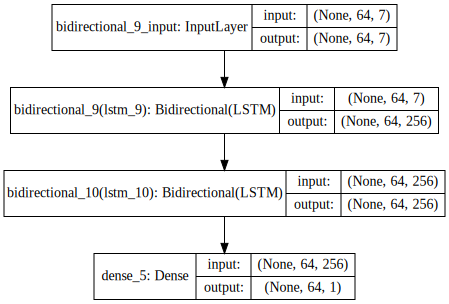

In [40]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64, n_input=7):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(PREDICT_SIZE, n_input)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [ ]:
model = create_model(l1=256, l2=256, n_input=55)

history = History()
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/50
21s - loss: 0.0278 - acc: 2.6930e-06 - r2: -1.5685e+00 - val_loss: 0.0088 - val_acc: 1.1490e-04 - val_r2: -4.4647e-02
Epoch 2/50
19s - loss: 0.0085 - acc: 0.0000e+00 - r2: 0.2083 - val_loss: 0.0060 - val_acc: 1.1490e-04 - val_r2: 0.2836
Epoch 3/50
19s - loss: 0.0075 - acc: 0.0000e+00 - r2: 0.3018 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.3078
Epoch 4/50
19s - loss: 0.0072 - acc: 0.0000e+00 - r2: 0.3274 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.3080
Epoch 5/50
19s - loss: 0.0071 - acc: 0.0000e+00 - r2: 0.3448 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.3033
Epoch 6/50
19s - loss: 0.0069 - acc: 0.0000e+00 - r2: 0.3624 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.2893
Epoch 7/50
19s - loss: 0.0066 - acc: 0.0000e+00 - r2: 0.3830 - val_loss: 0.0055 - val_acc: 1.1490e-04 - val_r2: 0.3140
Epoch 8/50
19s - loss: 0.0064 - acc: 0.0000e+00 - r2: 0.4102 - val_loss: 0.0055 - val_acc: 1.1490e-04 - val_

In [38]:
model = create_model(l1=256, l2=256, n_input=31)

history = History()
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/50
22s - loss: 0.0281 - acc: 2.6930e-06 - r2: -1.5992e+00 - val_loss: 0.0087 - val_acc: 1.1490e-04 - val_r2: -1.8350e-02
Epoch 2/50
19s - loss: 0.0086 - acc: 0.0000e+00 - r2: 0.1979 - val_loss: 0.0061 - val_acc: 1.1490e-04 - val_r2: 0.2719
Epoch 3/50
19s - loss: 0.0076 - acc: 0.0000e+00 - r2: 0.2907 - val_loss: 0.0057 - val_acc: 1.1490e-04 - val_r2: 0.3040
Epoch 4/50
19s - loss: 0.0074 - acc: 0.0000e+00 - r2: 0.3176 - val_loss: 0.0057 - val_acc: 1.1490e-04 - val_r2: 0.2952
Epoch 5/50
19s - loss: 0.0072 - acc: 0.0000e+00 - r2: 0.3356 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.2989
Epoch 6/50
19s - loss: 0.0070 - acc: 0.0000e+00 - r2: 0.3533 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.2894
Epoch 7/50
20s - loss: 0.0068 - acc: 0.0000e+00 - r2: 0.3725 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_r2: 0.3080
Epoch 8/50
19s - loss: 0.0065 - acc: 0.0000e+00 - r2: 0.3952 - val_loss: 0.0056 - val_acc: 1.1490e-04 - val_

In [8]:
model = create_model(l1=256, l2=256)

history = History()
model.fit(train_x, train_y, epochs=50, batch_size=BATCH_SIZE, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34812 samples, validate on 8703 samples
Epoch 1/50
20s - loss: 0.0286 - acc: 2.2442e-06 - r2: -1.6433e+00 - val_loss: 0.0104 - val_acc: 1.1490e-04 - val_r2: -2.3278e-01
Epoch 2/50
19s - loss: 0.0096 - acc: 0.0000e+00 - r2: 0.1087 - val_loss: 0.0075 - val_acc: 1.1490e-04 - val_r2: 0.1260
Epoch 3/50
19s - loss: 0.0085 - acc: 0.0000e+00 - r2: 0.2134 - val_loss: 0.0074 - val_acc: 1.1490e-04 - val_r2: 0.1211
Epoch 4/50
19s - loss: 0.0082 - acc: 0.0000e+00 - r2: 0.2422 - val_loss: 0.0073 - val_acc: 1.1490e-04 - val_r2: 0.1372
Epoch 5/50
19s - loss: 0.0080 - acc: 0.0000e+00 - r2: 0.2601 - val_loss: 0.0072 - val_acc: 1.1490e-04 - val_r2: 0.1414
Epoch 6/50
19s - loss: 0.0078 - acc: 0.0000e+00 - r2: 0.2771 - val_loss: 0.0072 - val_acc: 1.1490e-04 - val_r2: 0.1320
Epoch 7/50
19s - loss: 0.0076 - acc: 0.0000e+00 - r2: 0.2973 - val_loss: 0.0070 - val_acc: 1.1490e-04 - val_r2: 0.1733
Epoch 8/50
19s - loss: 0.0072 - acc: 0.0000e+00 - r2: 0.3311 - val_loss: 0.0066 - val_acc: 1.1490e-04 - val_

KeyboardInterrupt: 

In [ ]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

In [ ]:
vis_evaluate(model, test_x, test_y)